In [1]:
#THIS IS FOR STOCK ANALYSIS
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("C:/Users/John Lang/Documents/Data Science Machine Learning/Data Science/Tensorflow/DATA/RSCCASN.csv", parse_dates=True, index_col='DATE')

In [6]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [7]:
df.columns = ['Sales']

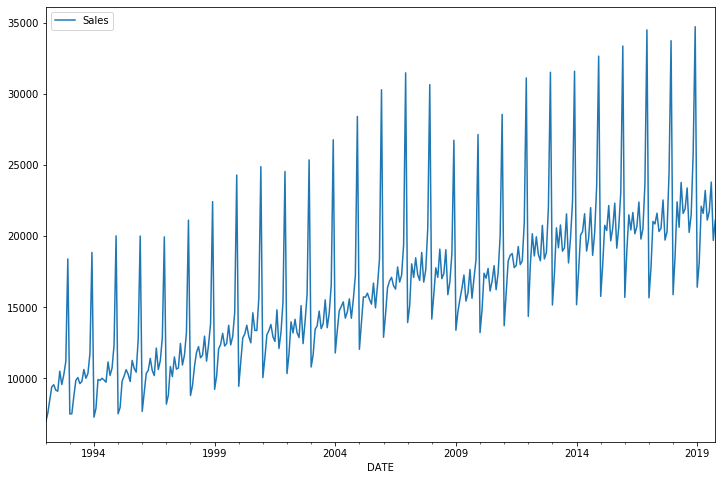

In [8]:
df.plot(figsize=(12,8))

In [9]:
len(df)

334

In [10]:
# 18 rows is 1.5 years, since it is months

In [11]:
test_size = 18
test_ind = len(df) - test_size

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
len(test)

18

In [19]:
# given length of 12 months, predict the 13th month
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [20]:
X,y = generator[0]
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [23]:
# y

In [24]:
# scaled_train

In [25]:
# create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [26]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size=1)
model.fit_generator(generator, epochs=20,
                   validation_data = validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0228 - val_loss: 0.0232
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0184 - val_loss: 0.0019
Epoch 3/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0041 - val_loss: 5.1046e-04
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0020 - val_loss: 9.7545e-04


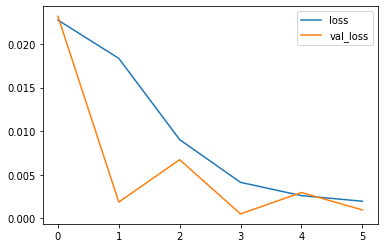

In [30]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [32]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
true_predictions = scaler.inverse_transform(forecast)

In [35]:
test['Forecast'] = true_predictions

C:\Users\John Lang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
test

,Sales,Forecast
DATE,,
2018-05-01,23764,21850.806339
2018-06-01,21589,20664.784554
2018-07-01,21919,20951.992358
2018-08-01,23381,22889.932513
2018-09-01,20260,20261.766861
2018-10-01,21473,20974.641945
2018-11-01,25831,25221.083366
2018-12-01,34706,36222.593556
2019-01-01,16410,16321.592323


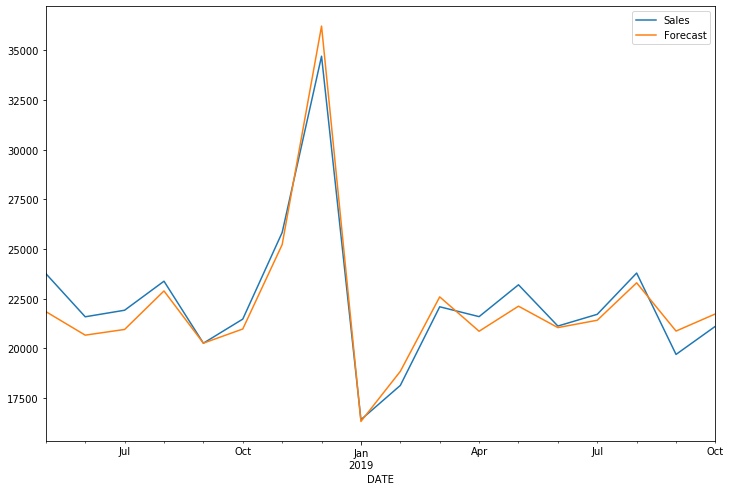

In [38]:
test.plot(figsize=(12,8))

In [39]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [40]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                               length=length, batch_size=1)

In [76]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=6)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/6
322/322 [==============================] - 3s 8ms/step - loss: 0.0271
Epoch 2/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0188
Epoch 3/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0103
Epoch 4/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0053
Epoch 5/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 6/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0019


In [77]:
forecast = []
# Replace periods with forecast length
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [78]:
forecast = scaler.inverse_transform(forecast)

In [79]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [80]:
forecast

array([[21900.6383872 ],
       [20849.93623161],
       [21049.20532036],
       [22797.66614437],
       [20512.62138677],
       [21060.68772221],
       [25066.46988678],
       [35870.41840839],
       [17280.54361939],
       [19293.92138195],
       [22601.30952072],
       [21111.15512753]])

In [81]:
# add with timestamp
forecast_index = pd.date_range(start = '2019-11-01', periods=periods,
                              freq="MS")

In [82]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

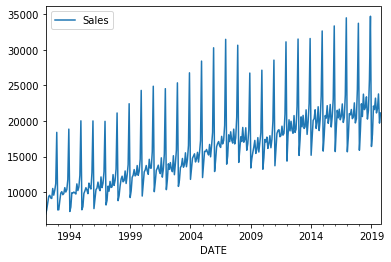

In [83]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                          columns=['Forecast'])
df.plot()

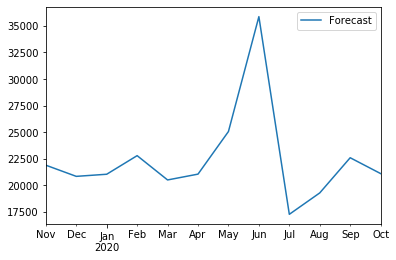

In [84]:
forecast_df.plot()

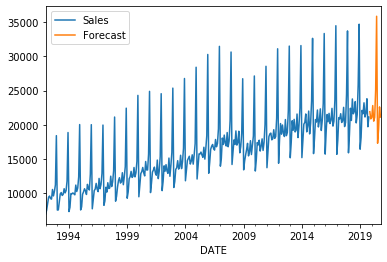

In [85]:
ax = df.plot()
forecast_df.plot(ax=ax)

array([[21907.78164291],
       [20789.29654121],
       [20991.18750525],
       [22798.75955009],
       [20433.48409534],
       [20991.08571672],
       [24684.02907133],
       [34887.04607582],
       [16855.95496845],
       [19165.73597836],
       [22625.57623243],
       [21068.23320675]])